# Data pre-processing

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

# Encode the target variable if necessary
if labels.dtype == 'object' or labels.dtype.name == 'category':
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [3]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Helper Functions

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import itertools
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

Best Accuracy: 0.6667
Best Params: {'hidden_size': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32}
Mean Cross-Validation Accuracy: 0.6444


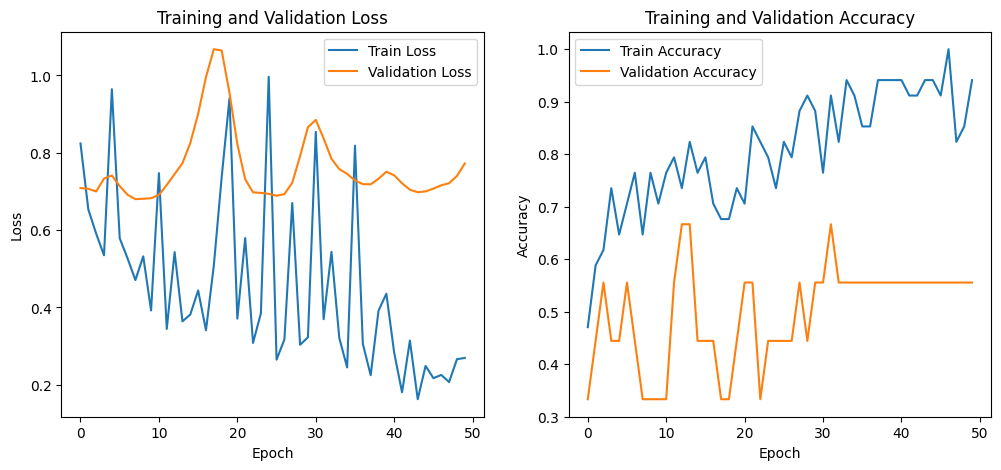

In [7]:
X = features
y = labels

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

def grid_search(train_loader, val_loader):
    hidden_sizes = [32, 64, 128]
    dropout_rates = [0.2, 0.5]
    learning_rates = [0.01, 0.001]
    batch_sizes = [32, 64]
    num_epochs = 50

    best_acc = 0
    best_params = {}

    for hidden_size, dropout_rate, lr, batch_size in itertools.product(hidden_sizes, dropout_rates, learning_rates, batch_sizes):
        model = SimpleNN(input_size, hidden_size, num_classes, dropout_rate)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == y_batch).sum().item()

        val_accuracy = val_correct / len(val_loader.dataset)

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_params = {
                'hidden_size': hidden_size,
                'dropout_rate': dropout_rate,
                'learning_rate': lr,
                'batch_size': batch_size
            }

    print(f'Best Accuracy: {best_acc:.4f}')
    print(f'Best Params: {best_params}')
    return best_params

# Perform grid search to find the best hyperparameters
best_params = grid_search(train_loader, val_loader)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_accuracies = []

for train_index, val_index in skf.split(X, y):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    train_dataset_cv = CustomDataset(X_train_cv, y_train_cv)
    val_dataset_cv = CustomDataset(X_val_cv, y_val_cv)

    train_loader_cv = DataLoader(train_dataset_cv, batch_size=best_params['batch_size'], shuffle=True)
    val_loader_cv = DataLoader(val_dataset_cv, batch_size=best_params['batch_size'], shuffle=False)

    model = SimpleNN(input_size, best_params['hidden_size'], num_classes, best_params['dropout_rate'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    train_model(model, criterion, optimizer, train_loader_cv, val_loader_cv, 50)

    model.eval()
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_cv:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y_batch).sum().item()

    val_accuracy = val_correct / len(val_loader_cv.dataset)
    cross_val_accuracies.append(val_accuracy)

mean_cross_val_accuracy = np.mean(cross_val_accuracies)
print(f'Mean Cross-Validation Accuracy: {mean_cross_val_accuracy:.4f}')

# Train the final model with the best hyperparameters
final_model = SimpleNN(input_size, best_params['hidden_size'], num_classes, best_params['dropout_rate'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(final_model, criterion, optimizer, train_loader, val_loader, 50)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


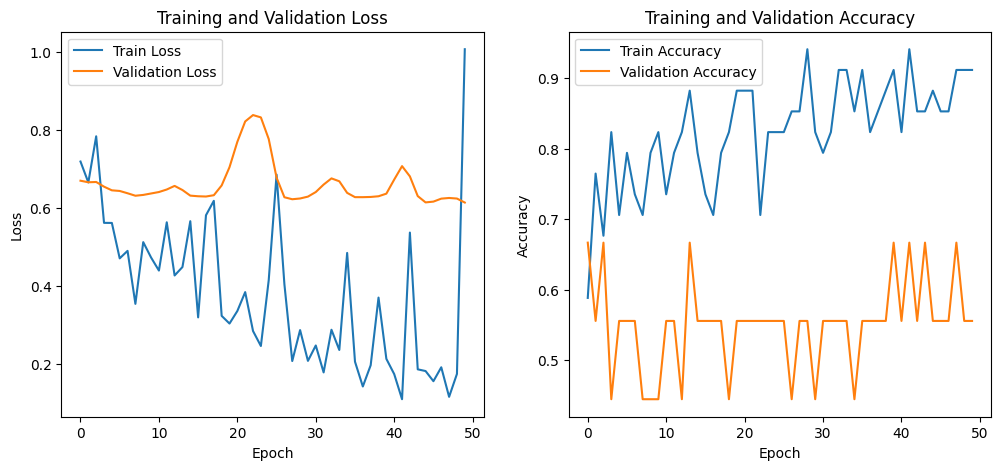

In [10]:
# Train the final model with the best hyperparameters
# final_model = SimpleNN(input_size, best_params['hidden_size'], num_classes, best_params['dropout_rate'])
final_model = SimpleNN(input_size, best_params['hidden_size'], num_classes, 0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(final_model, criterion, optimizer, train_loader, val_loader, 50)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

# Train Augmentation

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
def apply_pca(X_scaled, variance_threshold=0.99):
    pca = PCA()
    pca.fit(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
    print(
        f"Number of components needed to explain {variance_threshold * 100}% of the variance: {n_components}"
    )
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca


def generate_synthetic_samples(X_pca, y, num_samples=1000):
    synthetic_samples = []
    synthetic_subtypes = []
    unique_subtypes = np.unique(y)
    for subtype in unique_subtypes:
        subtype_indices = np.where(y == subtype)[0]
        num_subtype_samples = int(num_samples * len(subtype_indices) / len(y))
        for _ in range(num_subtype_samples):
            sample_idx = np.random.choice(subtype_indices)
            sample = np.copy(X_pca[sample_idx])
            perturbation = np.random.normal(0, 0.1, sample.shape) # 0.01 # 5000 
            synthetic_sample = sample + perturbation
            synthetic_samples.append(synthetic_sample)
            synthetic_subtypes.append(subtype)
    return np.array(synthetic_samples), np.array(synthetic_subtypes)


def inverse_transform_samples(synthetic_samples_pca, pca):
    return pca.inverse_transform(synthetic_samples_pca)

def augment_main(X_scaled, y):
    X_pca, pca = apply_pca(X_scaled)
    synthetic_samples_pca, synthetic_subtypes = generate_synthetic_samples(X_pca, y)
    synthetic_samples = inverse_transform_samples(synthetic_samples_pca, pca)
    X_new = np.concatenate([X_scaled, synthetic_samples], axis=0)
    y_new = np.concatenate([y, synthetic_subtypes], axis=0)

    return X_new, y_new

# main(features, labels)

Best Accuracy: 0.6667
Best Params: {'hidden_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32}
Number of components needed to explain 99.0% of the variance: 30
Number of components needed to explain 99.0% of the variance: 28
Number of components needed to explain 99.0% of the variance: 28
Number of components needed to explain 99.0% of the variance: 27
Number of components needed to explain 99.0% of the variance: 27
Mean Cross-Validation Accuracy: 0.6000


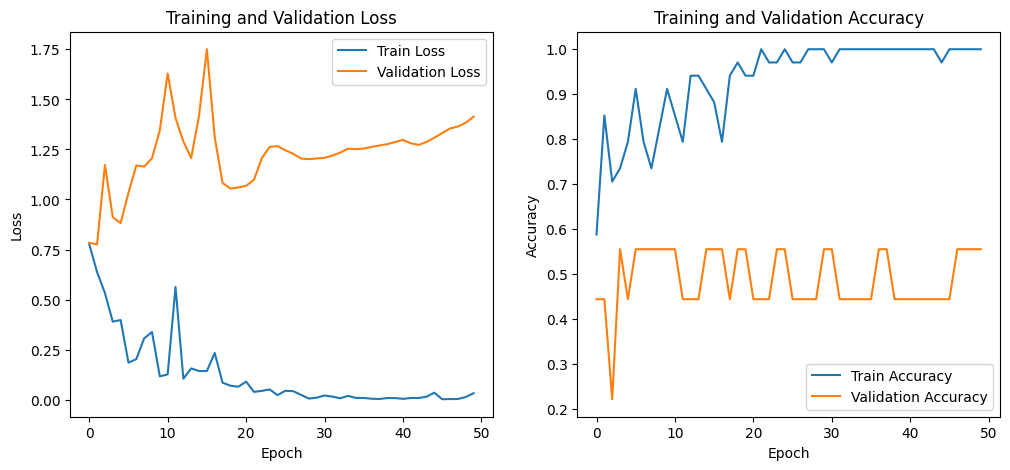

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        # print(
        #     f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}"
        # )

    return train_losses, val_losses, train_accuracies, val_accuracies


def grid_search(train_loader, val_loader):
    hidden_sizes = [32, 64, 128]
    dropout_rates = [0.2, 0.5]
    learning_rates = [0.01, 0.001]
    batch_sizes = [32, 64]
    num_epochs = 50

    best_acc = 0
    best_params = {}

    for hidden_size, dropout_rate, lr, batch_size in itertools.product(
        hidden_sizes, dropout_rates, learning_rates, batch_sizes
    ):
        model = SimpleNN(input_size, hidden_size, num_classes, dropout_rate)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == y_batch).sum().item()

        val_accuracy = val_correct / len(val_loader.dataset)

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_params = {
                "hidden_size": hidden_size,
                "dropout_rate": dropout_rate,
                "learning_rate": lr,
                "batch_size": batch_size,
            }

    print(f"Best Accuracy: {best_acc:.4f}")
    print(f"Best Params: {best_params}")
    return best_params


X = features
y = labels

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))


# Perform grid search to find the best hyperparameters
best_params = grid_search(train_loader, val_loader)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_accuracies = []

for train_index, val_index in skf.split(X, y):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    X_train, y_train = augment_main(X_train, y_train)

    train_dataset_cv = CustomDataset(X_train_cv, y_train_cv)
    val_dataset_cv = CustomDataset(X_val_cv, y_val_cv)

    train_loader_cv = DataLoader(
        train_dataset_cv, batch_size=best_params["batch_size"], shuffle=True
    )
    val_loader_cv = DataLoader(
        val_dataset_cv, batch_size=best_params["batch_size"], shuffle=False
    )

    model = SimpleNN(
        input_size, best_params["hidden_size"], num_classes, best_params["dropout_rate"]
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])

    train_model(model, criterion, optimizer, train_loader_cv, val_loader_cv, 50)

    model.eval()
    val_correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_cv:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y_batch).sum().item()

    val_accuracy = val_correct / len(val_loader_cv.dataset)
    cross_val_accuracies.append(val_accuracy)

mean_cross_val_accuracy = np.mean(cross_val_accuracies)
print(f"Mean Cross-Validation Accuracy: {mean_cross_val_accuracy:.4f}")

# Train the final model with the best hyperparameters
final_model = SimpleNN(
    input_size, best_params["hidden_size"], num_classes, best_params["dropout_rate"]
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
train_loader = DataLoader(
    train_dataset, batch_size=best_params["batch_size"], shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=best_params["batch_size"], shuffle=False
)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    final_model, criterion, optimizer, train_loader, val_loader, 50
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()
